# House Prices Dataset Analysis - *Given information about a house, predict its price*

Last updated: October 2020

## How is this useful?

Being able to accuractely predict the price of houses is obviously a very powerful tool. For example, one can use a model to predict the price of a house based on information that they have, which can then be compared with what it has been valued at by an agent. If you find that the house has been listed for lower than what the model thinks it's worth, you could purchase the house and relist it for the higher price that the model predicted in order to make profit. Also, if your model was really good, you could sell it to some real estate agency to cut out the need for valuing houses.

## About the Dataset

This dataset contains information about various houses in the US. The dataset is of shape (1460,81), meaning we have 1460 observations of 81 features. The features are things like:

* Overall quality
* Basement surface area
* Condition of internal/external materials
* Garage size
* Garage condition etc.

The data is open source and can be viewed/downloaded from https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## About this Notebook

This notebook is split into 4 parts:

### Part 1: Dataset Exploration & Feature Engineering
    1. Viewing the Data
    2. Label Encoding Ordinal Features
    3. Addressing Missing Values
### Part 2: Dataset Preprocessing
    1. Independent/Dependent Variable Split + Feature Scaling
### Part 3: Model Training & Prediction
    1. Fitting XGBoost
    2. Predicting the Test Set Prices
    3. Regression Model Comparison
### Part 4: Summary and Conclusions
    1. Key Takeaways
    2. Limitations
    3. Future Work

## Part 1: Dataset Exploration and Feature Engineering

### 1) Viewing the Data

First we print the shape of the training set and find that it is 1460x81. 81 is an extremely high number of features, and we can tell from the beginning that we will likely have to do some feature engineering and filtering in order to use the features that are strong predictors of house price.

Another to notice is that the test set contains 1 fewer feature compared to the training set. This feature is the dependent variable that we are trying to predict (sale price). The feature is omitted because Kaggle calculates the quality of the predictions. Therefore, we do not need to establish an evaluation pipeline.

In [237]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# read in the dataset, print shape and column titles
train_set = pd.read_csv('train.csv')
print("Training set shape: ", train_set.shape)

test_set = pd.read_csv('test.csv')
print("Test set shape: ", test_set.shape)

Training set shape:  (1460, 81)
Test set shape:  (1459, 80)


We now plot a histogram of the dependent variable (sale price). Interestingly, the sale price is not normally distributed and is right skewed.

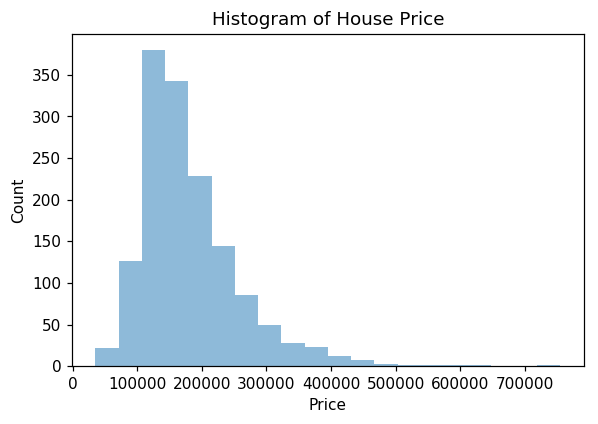

In [238]:
saleprice = train_set.iloc[:,-1].values

plt.figure(dpi=110)
plt.hist(saleprice,20,alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Histogram of House Price')
plt.show()

When we apply feature engineering, we need to apply the same operations to the training and test sets. To have having to repeat ourselves, we will concatenate the training and test sets into one large dataframe. Note that because the test set does not have a saleprice column, we drop the saleprice column from the training set (this is ok since we have already extracted the saleprice data to make the histogram above. We also drop the ID column since it is not related to the dependent variable.

In [239]:
intermediate = train_set.drop(columns=['SalePrice'])
dataset = pd.concat([intermediate, test_set])
dataset = dataset.drop(columns=['Id'])
print(dataset.shape)

(2919, 79)


### 2) Feature Engineering

From looking at the meta data, there are many categorical columns (>50), but a lot of the categorical columns are just numerical scales that are represented with words instead. For example, ExterQual is a feature describing the quality of the materials used for the exterior of the property and takes values from 'Ex' meaning Excellent to 'Po' meaning Poor. In reality this is just code for an ordinal scale with 5 levels. Since many columns in the dataset are like this (but with different codes), we can define a custom mapping between the column values and numerical labels and use OrdinalEncoder to transform each column.

In [240]:
ordinal_cols_mapping = [{
    "col": "ExterQual",
    "mapping": {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }}, {
    "col": "ExterCond",
    "mapping": {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }}, {
    "col": "BsmtQual",
    "mapping": {
        "NA": None,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    }}, { 
    "col": "BsmtCond",
    "mapping": {
        "NA": None,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    }}, {
    "col": "BsmtExposure",
    "mapping": {
        "NA": None,
        "No": 1,
        "Mn": 2,
        "Av": 3,
        "Gd": 4
    }}, {
    "col": "BsmtFinType1",
    "mapping": {
        "NA": None,
        "Unf": 1,
        "LwQ": 2,
        "Rec": 3,
        "BLQ": 4,
        "ALQ": 5,
        "GlQ": 6
    }}, {
    "col": "BsmtFinType2",
    "mapping": {
        "NA": None,
        "Unf": 1,
        "LwQ": 2,
        "Rec": 3,
        "BLQ": 4,
        "ALQ": 5,
        "GlQ": 6
    }}, {
    "col": "HeatingQC",
    "mapping": {
        "Po": 0,
        "Fa": 1,
        "TA": 2,
        "Gd": 3,
        "Ex": 4
    }}, {
    "col": "CentralAir",
    "mapping": {
        "N": None,
        "Y": 1
    }}, {
    "col": "KitchenQual",
    "mapping": {
        "Po": 0,
        "Fa": 1,
        "TA": 2,
        "Gd": 3,
        "Ex": 4
    }}, {
    "col": "Functional",
    "mapping": {
        "Sal": 0,
        "Sev": 1,
        "Maj2": 2,
        "Maj1": 3,
        "Mod": 4,
        "Min2": 5,
        "Min1": 6,
        "Typ": 7
    }}, {
    "col": "FireplaceQu",
    "mapping": {
        "NA": None,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    }}, {
    "col": "GarageType",
    "mapping": {
        "NA": None,
        "Detchd": 1,
        "CarPort": 2,
        "BuiltIn": 3,
        "Basment": 4,
        "Attchd": 5,
        "2Types": 6
    }}, {
    "col": "GarageFinish",
    "mapping": {
        "NA": None,
        "Unf": 1,
        "RFn": 2,
        "Fin": 3
    }}, {
    "col": "GarageQual",
    "mapping": {
        "NA": None,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    }}, {
    "col": "GarageCond",
    "mapping": {
        "NA": None,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    }}, {
    "col": "PoolQC",
    "mapping": {
        "NA": None,
        "Fa": 1,
        "TA": 2,
        "Gd": 3,
        "Ex": 4
    }}, {
    "col": "Fence",
    "mapping": {
        "NA": None,
        "MnWw": 1,
        "GdWo": 2,
        "MnPrv": 3,
        "GdPrv": 4
    }}
]

import category_encoders as ce
encoder = ce.OrdinalEncoder(mapping = ordinal_cols_mapping, 
                             return_df = True)

dataset = encoder.fit_transform(dataset)

We can now remove all of the truly categorical features and we are left with only the numerical columns, which will work with our regression model.

After doing this the training set has 56 features.

In [241]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical = dataset.select_dtypes(include=numerics)
print(numerical.shape)

(2919, 54)


### 3) Addressing Missing Values

We must now deal with missing values in our dataset. We can do this by plotting a chart of the percentage of `NaN` values in each column.

We observe that 3 features contain `NaN` values, the largest of which has around 17.5% of the column as `NaN`. From experimenting, for this particular dataset, it is actually better to just remove these features instead of imputing, so we drop the columns.

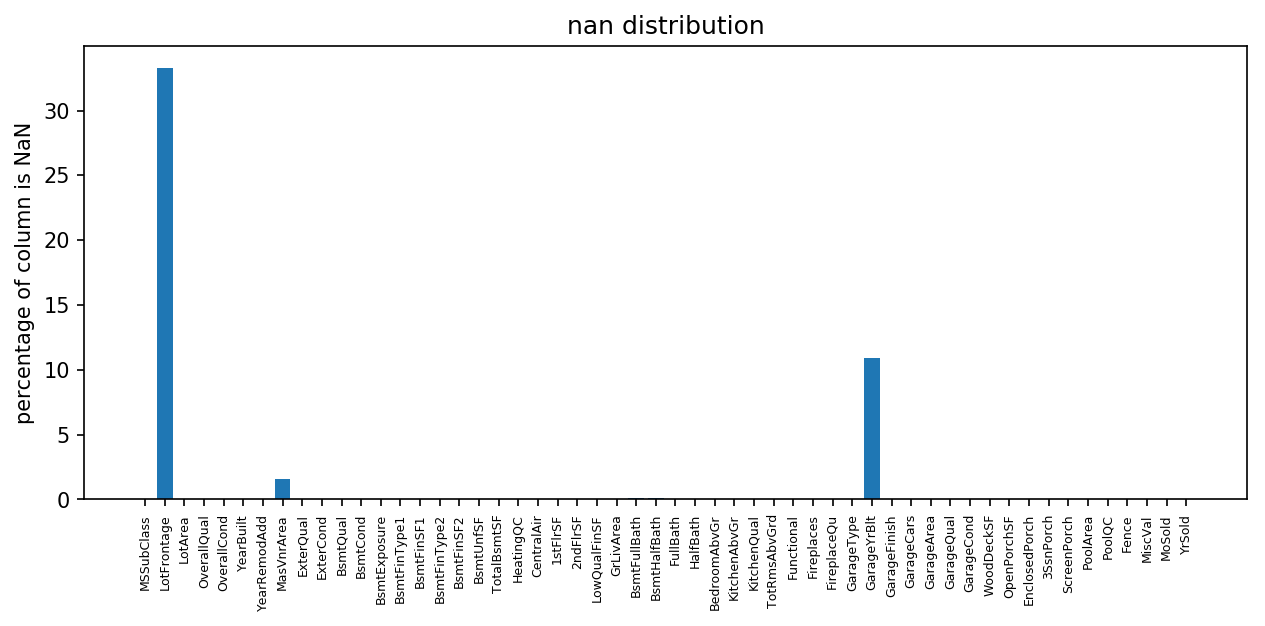

In [242]:
# count number of NaN values in the columns
nans = []
all_nans = numerical.isna().sum()

for i in range(len(all_nans)):
    nans.append((all_nans[i]/1460)*100)

# plot the number of NaN values per column
plt.figure(dpi=150,figsize=(10,4))
plt.bar(list(numerical.columns), nans)
plt.xticks([i for i in range(len(list(numerical.columns)))], list(numerical.columns), rotation='vertical', fontsize=6)
plt.title('nan distribution')
plt.ylabel('percentage of column is NaN')
plt.show()

numerical = numerical.drop(columns=["LotFrontage", "GarageYrBlt", 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                                    'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea', 'TotalBsmtSF'])

In order to see which variables are well correlated with sale price, we can produce a correlation matrix. We can see that there are several features that are well correlated with sale price and this is a good indication that we can build a strong model using our dataset.

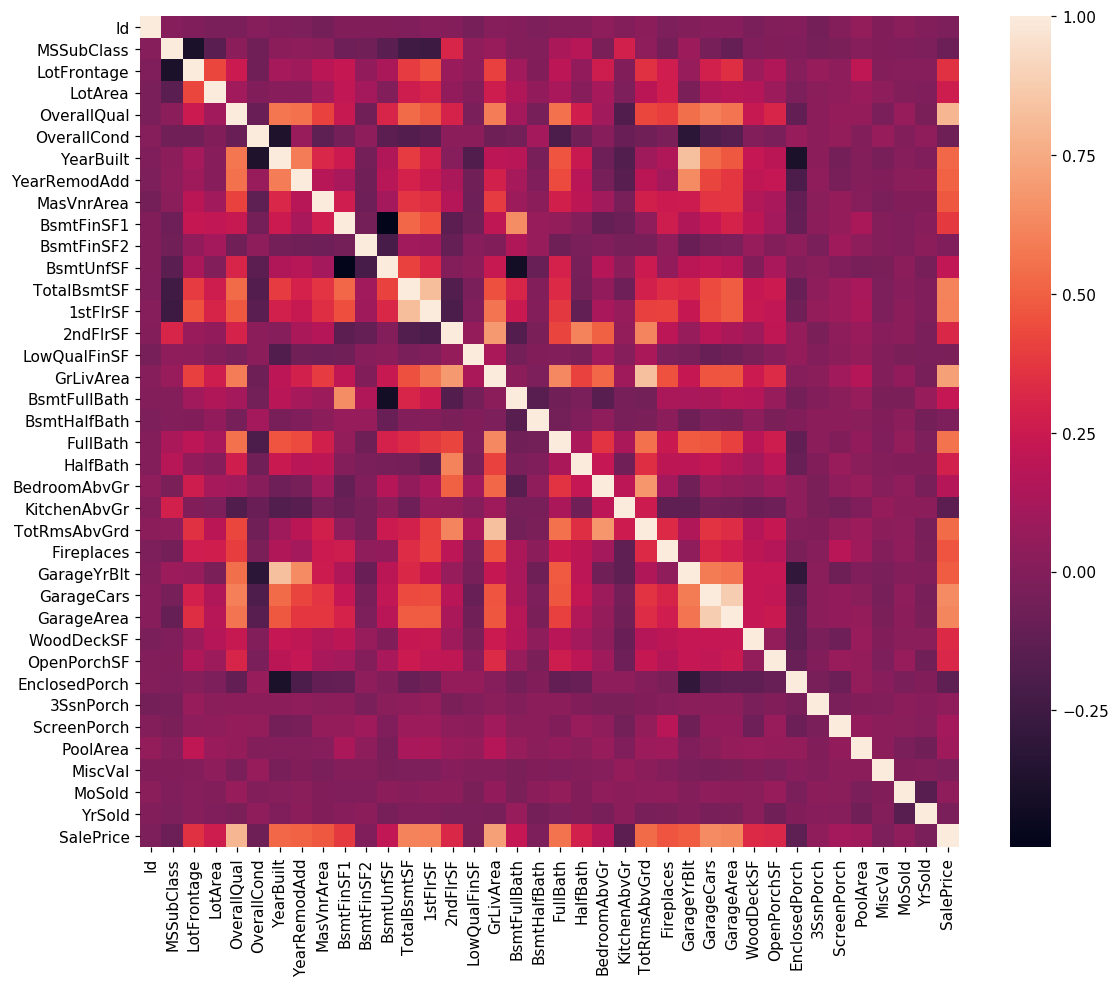

In [243]:
import seaborn as sn

correlated_features = set()
correlation_matrix = train_set.corr()

plt.figure(dpi=110,figsize=(12,10))
sn.heatmap(correlation_matrix, annot=False)
plt.show()

## Part 2: Dataset Preprocessing

### 1) Independent/Dependent Variable Split + Feature Scaling

Since all the exploration is done, we can now split the dataset into the independent and dependent variables. We also need to apply feature scaling to both the independent and dependent variables.

In [244]:
numerical_train = numerical.iloc[0:1460,:].values
numerical_test = numerical.iloc[1460:,:].values

print(numerical_train.shape)
print(numerical_test.shape)

X_train = numerical_train
y_train = saleprice

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X_train)
y = sc_y.fit_transform(y_train.reshape(-1,1))

(1460, 44)
(1459, 44)


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Part 3: Model Training & Prediction

### 1) Fitting XGBoost

We now fit our regression model, which will be the XGBoost regressor. The XGBoost regressor often has the best 
performance when compared to other regression models like SVR and Random Forest.

In [245]:
# fitting XGboost to the training set
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

### 2) Predicting the Test Set Prices

We create a list of the predicted values for the house prices of the test set. We can visualise the predicitons and compare the distribution of the predicted values to the training set values in order to see if we are on the right track.

We can see that the two distributions are very similar in general shape, our predicted prices are also left skewed, with a mode of around $150000. This is a very good sign that our predictions are accurate. However, the predicted distribution is slightly less sharply peaked compared with the training set distribution.

[133205.78 177539.53 177646.4  ... 174431.44 115140.04 195706.75]


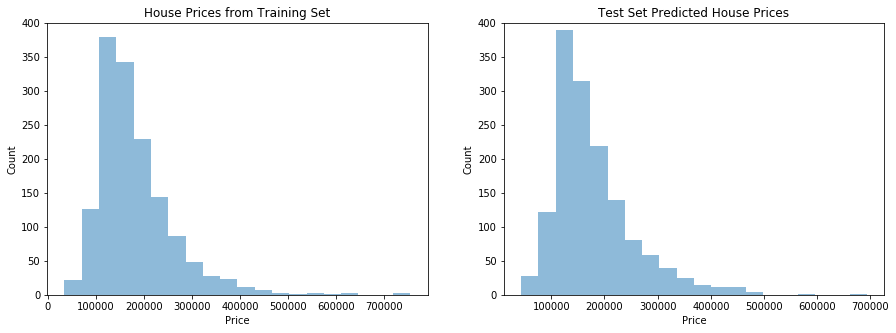

In [246]:
y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(numerical_test)))
print(y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.hist(y_train, 20, alpha=0.5)
ax1.set_title('House Prices from Training Set')
ax1.set_xlabel('Price')
ax1.set_ylim([0,400])
ax1.set_ylabel('Count')

ax2.hist(y_pred, 20, alpha=0.5)
ax2.set_title('Test Set Predicted House Prices')
ax2.set_xlabel('Price')
ax2.set_ylim([0,400])
ax2.set_ylabel('Count')
plt.show()

Finally, we save our predictions as a csv file so that Kaggle can calculate the RMSE.

In [247]:
ids = list(test_set.iloc[:,0].values)

predictions = pd.DataFrame(y_pred,index=ids)
predictions.rename(columns={ predictions.columns[0]: "SalePrice" }, inplace = True)
predictions = predictions.rename_axis("Id")

predictions.to_csv('predictons.csv')

### 3) Regression Model Comparison

We can compare the score achieved by the XGBoost Regressor vs other regression models by plotting the RMSE. Since Kaggle calculates the RMSE for us, we have not trained these models here. We can see that the XGBoost model produces the lowest RMSE of all the models.

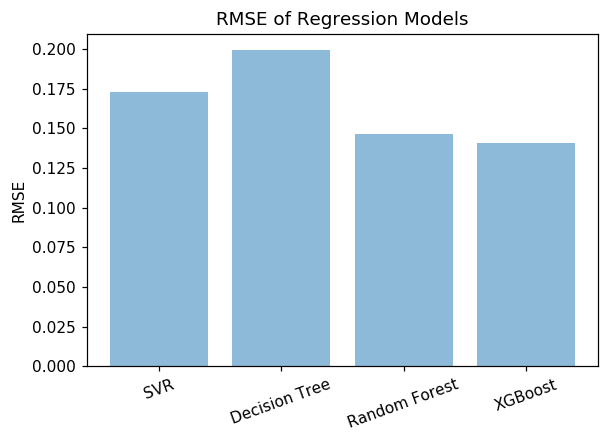

In [221]:
models = ['SVR', 'Decision Tree', 'Random Forest', 'XGBoost']
rsme = [0.17260, 0.19934, 0.14609, 0.14045]

# plot the number of NaN values per column
plt.figure(dpi=110)
plt.bar(models, rsme, alpha = 0.5)
plt.xticks([i for i in range(len(models))], models, rotation=20)
plt.title('RMSE of Regression Models')
plt.ylabel('RMSE')
plt.show()

## Part 4: Conclusion

### 1) Key Takeaways

### 2) Limitations & Future Work